In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sympy import fraction
from torch.ao.nn.quantized.functional import threshold
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim


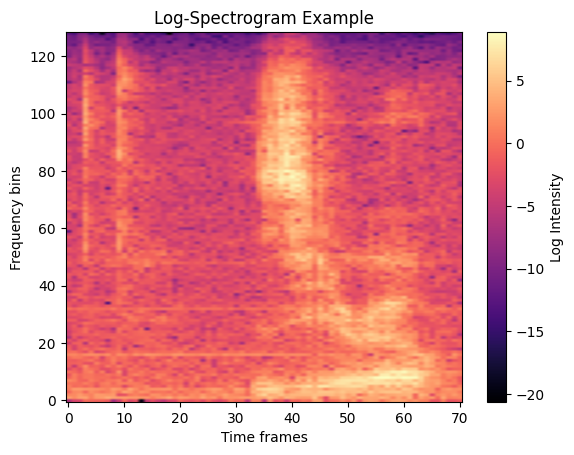

In [4]:
y = np.load('y_digits.npy')
x = np.load('x_digits.npy')

plt.imshow(x[2], aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Log Intensity")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Log-Spectrogram Example")
plt.show()

In [5]:
X_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=1)
Y_tensor = torch.tensor(y, dtype=torch.float32)

dataset_size = len(X_tensor)

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, Y_tensor, test_size=0.3, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

torch.Size([24941, 1, 129, 71]) torch.Size([5345, 1, 129, 71]) torch.Size([5345, 1, 129, 71]) torch.Size([24941]) torch.Size([5345]) torch.Size([5345])


In [6]:
import torch.nn as nn


def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.classes = 10
        conv_blks = []
        for i in range(3):
            conv_blks.append(vgg_block(3, 256))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
        )

        dummy_input = torch.zeros(1, 1, 129, 71)
        dummy_input.to("cuda")
        with torch.no_grad():
            self.net_output = self.net(dummy_input).size(1)

        self.detection_head = nn.Sequential(
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        x = self.net(x)

        logits = self.detection_head(x)
        pred_digits = torch.argmax(logits, dim=1)
        return logits, pred_digits


In [7]:
batch_size = 128
device = "cuda"

X_reduced, X_left, y_reduced, y_left = train_test_split(X_temp, y_temp, test_size=0.85, stratify=y_temp)
X_val_reduced, X_val_left, y_val_reduced, y_val_left = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

dataset = TensorDataset(X_train, y_train)
full_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [8]:
from torch.utils.data import SubsetRandomSampler

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True, threshold=0.01)

patience = 3
threshold = 0.01
best_val_loss = 9999999
counter = 0
subset_size = int(0.3 * len(dataset))
val_losses = []
train_losses = []

for epoch in range(num_epochs):

    dataloader = full_dataloader
    fraction = 0.3
    actual_batches = 0
    discarded_batches = 0
    discard_limit = (1 - fraction) * len(dataloader)
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(dataloader):
        if torch.rand(1).item() > fraction and discarded_batches < discard_limit:
            discarded_batches += 1
            continue
        actual_batches += 1
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).type(torch.long)

        optimizer.zero_grad()
        logits, arg_max_pred = model(images)

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f": Loss = {loss.item():.4f}, actual_batches = {actual_batches}")

    avg_loss = total_loss / actual_batches
    print(f":Epoch finished, looking at validation set...")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).long()

            logits, _ = model(images)
            loss = loss_fn(logits, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f},  lr = {optimizer.param_groups[0]['lr']}")
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    if best_val_loss - avg_val_loss > threshold:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model.")
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "Net_best.pth")
    else:
        print(f"No significant improvement in validation loss. Best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f} for {counter+1} epochs.")
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


/home/user/pythonenv/default/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  3%|▎         | 5/195 [00:03<02:06,  1.50it/s]

: Loss = 2.3034, actual_batches = 1


  4%|▎         | 7/195 [00:06<03:01,  1.04it/s]

: Loss = 2.3014, actual_batches = 2


  5%|▍         | 9/195 [00:09<03:29,  1.12s/it]

: Loss = 2.2977, actual_batches = 3


  7%|▋         | 14/195 [00:14<03:12,  1.06s/it]

: Loss = 2.3034, actual_batches = 4


  9%|▉         | 18/195 [00:17<02:47,  1.05it/s]

: Loss = 2.3073, actual_batches = 5


 10%|█         | 20/195 [00:20<03:08,  1.08s/it]

: Loss = 2.3001, actual_batches = 6


 10%|█         | 20/195 [00:21<03:07,  1.07s/it]


KeyboardInterrupt: 

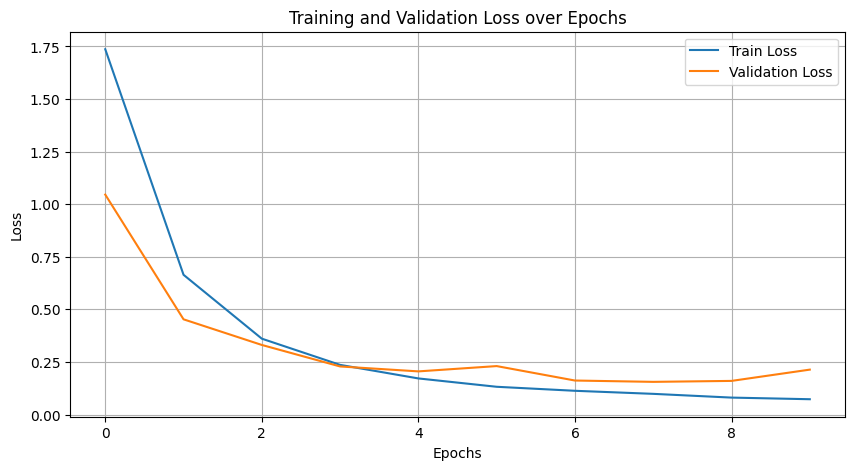

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [6]:

model = Net()
model = model.to(device)
model.load_state_dict(torch.load("Net_best.pth", map_location=device))

model.eval()
avg_train_performance = 0.0
avg_val_performance = 0.0
for images, targets in tqdm(full_dataloader):
    images = images.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True).type(torch.long)

    logits, arg_max_pred = model(images)

    avg_train_performance += (arg_max_pred == targets).sum().item() / targets.size(0)

avg_train_performance = avg_train_performance / len(full_dataloader)
print(f"Train Accuracy: {avg_train_performance:.4f}")

model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, targets in val_dataloader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).type(torch.long)
        logits, arg_max_pred = model(images)

        avg_val_performance += (arg_max_pred == targets).sum().item() / targets.size(0)

avg_val_performance = avg_val_performance / len(val_dataloader)
print(f"Train Performance = {avg_train_performance:.4f}, Val Performance = {avg_val_performance:.4f}")

/home/user/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:736: UserWarning: Can't initialize amdsmi - Error code: 34
  warnings.warn(f"Can't initialize amdsmi - Error code: {e.err_code}")
100%|██████████| 195/195 [03:09<00:00,  1.03it/s]


Train Accuracy: 0.9669
Train Performance = 0.9669, Val Performance = 0.9617


Iteration 1/50
Loss = 2.3019
Iteration 2/50
Loss = 2.3025
Iteration 3/50
Loss = 2.3020
Iteration 4/50
Loss = 2.3021
Iteration 5/50
Loss = 2.3056
Iteration 6/50
Loss = 2.3014
Iteration 7/50
Loss = 2.3035
Iteration 8/50
Loss = 2.3018
Iteration 9/50
Loss = 2.3027
Iteration 10/50
Loss = 2.3049
Iteration 11/50
Loss = 2.3029
Iteration 12/50
Loss = 2.3010
Iteration 13/50
Loss = 2.3012
Iteration 14/50
Loss = 2.2998
Iteration 15/50
Loss = 2.3040
Iteration 16/50
Loss = 2.3046
Iteration 17/50
Loss = 2.3036
Iteration 18/50
Loss = 2.2975
Iteration 19/50
Loss = 2.2949
Iteration 20/50
Loss = 2.2874
Iteration 21/50
Loss = 2.2439
Iteration 22/50
Loss = 2.1717
Iteration 23/50
Loss = 2.1365
Iteration 24/50
Loss = 2.0179
Iteration 25/50
Loss = 1.9814
Iteration 26/50
Loss = 1.9228
Iteration 27/50
Loss = 2.0511
Iteration 28/50
Loss = 1.9730
Iteration 29/50
Loss = 1.9601
Iteration 30/50
Loss = 1.9109
Iteration 31/50
Loss = 1.7833
Iteration 32/50
Loss = 1.8482
Iteration 33/50
Loss = 2.6822
Iteration 34/50
Los

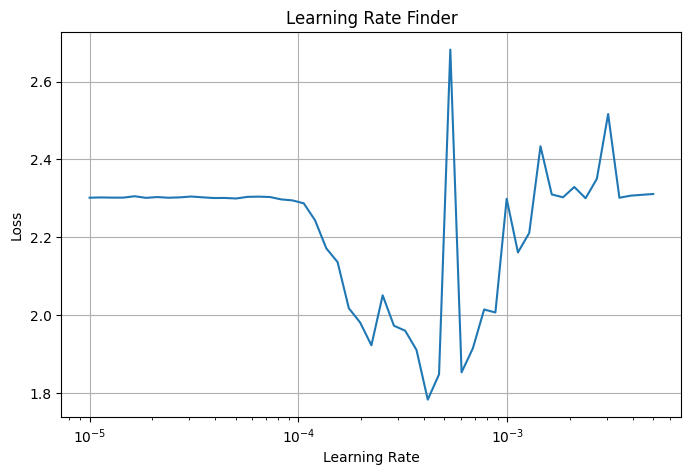

In [6]:
import torch
from torch import nn, optim

dataset = TensorDataset(X_train, y_train)
full_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7)
loss_fn = nn.CrossEntropyLoss()

lrs = []
losses = []

lr_start = 1e-5
lr_end = 0.5e-2
num_iters = 50
mult = (lr_end / lr_start) ** (1/num_iters)
lr = lr_start

for i, (X_batch, y_batch) in enumerate(full_dataloader):
    if i > num_iters:
        break

    print(f"Iteration {i+1}/{num_iters}")
    X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.long)
    optimizer.zero_grad()

    logits, arg_max_pred = model(X_batch)

    loss = loss_fn(logits, y_batch)
    loss.backward()
    print(f"Loss = {loss.item():.4f}")
    optimizer.step()

    lrs.append(lr)
    losses.append(loss.item())


    lr *= mult
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

plt.figure(figsize=(8,5))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.grid(True)
plt.show()